In [4]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from sklearn.datasets import make_blobs
from inspect import signature as sig
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Pipeline 파이썬 클래스 
데이터 변환 과정(전처리)과 머신러닝 모델을 이용하기 쉽게 추정기 형태로 연결해줍니다.


## cf ) 여기서 두 가지 함정이 있다!
1. 데이터의 최솟값과 최댓값을 계산하면서 스케일을 학습할 때 훈련 세트에 있는 모든 데이터(훈련용+검증용)를 모두 사용했습니다. 

  -> 검증 폴드 데이터의 정보가 이미 누설됐으므로 교차 검증에서 최적의 매개변수를 찾지 못하고 낙관적인 결과가 만들어지게 됩니다. 
  

<!-- 2. 테스트 데이터는 훈련 데이터의 스케일 조정 단계에서 고려되지 않았기 때문에, 그 최솟값과 최댓값이 훈련 데이터와 다를 수 있습니다. 

  -> 즉, 스케일할 때 모르던 데이터라 스케일이 맞지 않을 수 있습니다. ???????????? --> 

In [5]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state = 0)

# 훈련 데이터의 최솟값, 최댓값 계산(학습)
scaler = MinMaxScaler().fit(X_train)

# 훈련 데이터와 테스트 데이터의 스케일을 조정(변환)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # 모델 생성
# svm = SVC()
# # 스케일 조정된 훈련 데이터에 SVM을 학습시키고, 테스트 데이터를 넣어 점수를 계산한다. 
# svm.fit(X_train_scaled, y_train)
# print("테스트 점수: " , svm.score(X_test_scaled , y_test))

from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.001,0.01,0.1,1,10,100], 'gamma' :[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최적 파라미터의 교차 검증 정확도 : ", grid.best_score_)
print("최종 테스트 셋의 점수 : ", grid.score(X_test_scaled, y_test))
print("최적의 매개변수 조합 : ", grid.best_params_)

최적 파라미터의 교차 검증 정확도 :  0.9812311901504789
최종 테스트 셋의 점수 :  0.972027972027972
최적의 매개변수 조합 :  {'C': 1, 'gamma': 1}


# 1. 가장 간단한 파이프라인 만들어보기
튜플은 알다시피 순서가 있습니다. 첫번째 scaler 객체로 훈련 데이터를 학습/변환하고, 두번째로 변환된 데이터를 가지고 SVM 모델을 훈련시킵니다.

-> 장점 : 작성해야 할 코드가 줄어듭니다. 

In [6]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm",SVC())])  
pipe.fit(X_train, y_train)
print("테스트 점수 : ", pipe.score(X_test, y_test))

테스트 점수 :  0.972027972027972


# 2. 그리드 서치에 파이프라인 적용하기 
파이프라인의 가장 큰 장점은 cross_val_score나 GridSearchCV에 파이프라인을 적용해 하나의 추정기처럼 사용할 수 있다는 것입니다.

0. 훈련+검증 세트와 테스트 세트를 분할

* 한 파라미터 조합에 대해서
 
 
1. 훈련+검증 세트를 폴드 분할을 하고

* 한 분할에 대해서
 
 
2. 훈련세트를 스케일링(학습/변환)하고
3. SVC학습 -> 2,3 과정은 pipeline으로 묶여 있다! 쎄뚜쎄뚜!
4. 검증 세트로, 평가


5. 다음 분할로 넘어가서 2~4를 반복한다.
6. 다음 파라미터 조합으로 넘어가서 1과 2~4를 반복한다.

#### => 교차 검증의 각 분할에 MinMaxScaler 가 훈련 폴드에 매번 적용되어, 매개변수 검색 과정에서 검증 폴더의 정보가 누설되지 않는다!

In [7]:
param_grid = {'svm__C':[0.001,0.01,0.1,1,10,100], 'svm__gamma' :[0.001,0.01,0.1,1,10,100]}

grid = GridSearchCV(pipe, param_grid = param_grid, cv=5)
grid.fit(X_train, y_train)

print("최종 테스트 셋의 점수 : ",grid.score(X_test, y_test))
print("최적 파라미터의 교차 검증 정확도 : ", grid.best_score_)
print("최적의 매개변수 조합 : ", grid.best_params_)

print(grid.best_estimator_)
print(grid.best_estimator_.named_steps["scaler"])

최종 테스트 셋의 점수 :  0.972027972027972
최적 파라미터의 교차 검증 정확도 :  0.9812311901504789
최적의 매개변수 조합 :  {'svm__C': 1, 'svm__gamma': 1}
Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC(C=1, gamma=1))])
MinMaxScaler()


- 파이프라인 객체는 두 모델을 합쳐서 하나의 모델처럼 연달아 수행한다고 생각하면 편하다. 
- 결국, 그리드 서치로 나온 best_estimator_는 scaler와 svm 두 단계를 가진 파이프라인 객체이다!

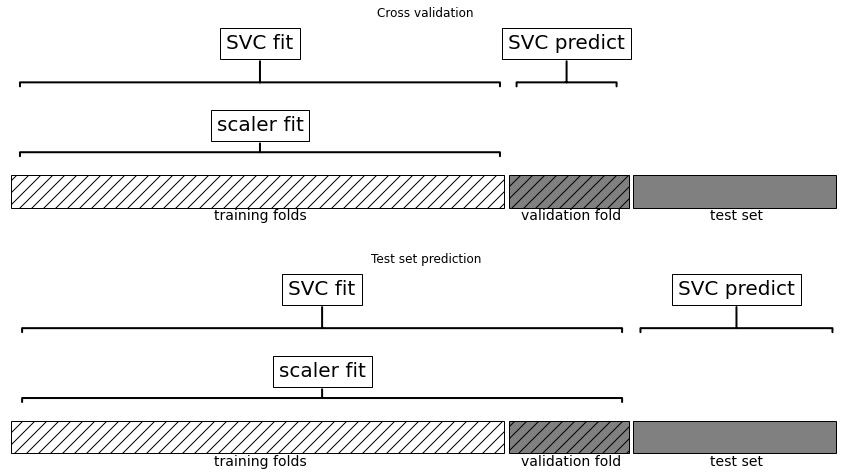

In [8]:
mglearn.plots.plot_proper_processing()

In [9]:
# 파이프라인 객체의 속성 - steps, named_steps
print(pipe.steps) # 각 단계의 이름과 모델종류를 보여준다. 
print(type(pipe.steps))
print(pipe.named_steps)
print(type(pipe.named_steps)) # 튜플같은 느낌으로 key로 접근 가능!(각 단계 모델에 접근하는 방법)
pipe.named_steps["scaler"]

[('scaler', MinMaxScaler()), ('svm', SVC())]
<class 'list'>
{'scaler': MinMaxScaler(), 'svm': SVC()}
<class 'sklearn.utils.Bunch'>


MinMaxScaler()

# 모델 선택을 위한 그리드 서치

In [10]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [11]:
param_grid = [
    {'classifier':[SVC()], 'preprocessing':[StandardScaler()],
    'classifier__gamma':[0.001,0.01,0.1,1,10,100],
    'classifier__C':[0.001,0.01,0.1,1,10,100]},
     {'classifier':[RandomForestClassifier(n_estimators=100)], 'preprocessing':[None],
    'classifier__max_features':[1,2,3]}
]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))

print(grid.best_params_)
print(grid.best_score_)

0.9790209790209791
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
0.9858823529411765


=> 그리드 서치의 결과는 StandardScaler 전처리를 사용하고 C=10, gamma=0.01인 SVC에서 최상의 결과를 얻었습니다.

In [13]:
results = pd.DataFrame(grid.cv_results_)
results.tail(25)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__gamma,param_preprocessing,param_classifier__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.011292,0.000842,0.004562,0.002090,"SVC(C=10, gamma=0.01)",0.1,0.1,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.918605,0.964706,0.917647,0.917647,0.952941,0.934309,0.020362,14
15,0.021784,0.004446,0.004992,0.000822,"SVC(C=10, gamma=0.01)",0.1,1,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.627907,0.635294,0.623529,0.623529,0.623529,0.626758,0.004593,19
16,0.018964,0.002460,0.003953,0.000600,"SVC(C=10, gamma=0.01)",0.1,10,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.627907,0.635294,0.623529,0.623529,0.623529,0.626758,0.004593,19
17,0.011498,0.000182,0.002947,0.000376,"SVC(C=10, gamma=0.01)",0.1,100,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.627907,0.635294,0.623529,0.623529,0.623529,0.626758,0.004593,19
18,0.007902,0.000742,0.001997,0.000207,"SVC(C=10, gamma=0.01)",1,0.001,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.918605,0.964706,0.929412,0.964706,0.941176,0.943721,0.018562,11
19,0.005458,0.000872,0.001602,0.000511,"SVC(C=10, gamma=0.01)",1,0.01,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.953488,0.976471,0.952941,0.976471,0.988235,0.969521,0.013991,5
20,0.009151,0.001260,0.001980,0.000183,"SVC(C=10, gamma=0.01)",1,0.1,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.965116,0.964706,0.929412,0.964706,0.941176,0.953023,0.014947,9
21,0.019622,0.002285,0.003940,0.000454,"SVC(C=10, gamma=0.01)",1,1,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.639535,0.635294,0.623529,0.635294,0.623529,0.631436,0.006639,16
22,0.018429,0.003742,0.003970,0.000493,"SVC(C=10, gamma=0.01)",1,10,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.627907,0.635294,0.623529,0.623529,0.623529,0.626758,0.004593,19
23,0.012704,0.000946,0.003320,0.000861,"SVC(C=10, gamma=0.01)",1,100,StandardScaler(),NaN,"{'classifier': SVC(C=10, gamma=0.01), 'classif...",0.627907,0.635294,0.623529,0.623529,0.623529,0.626758,0.004593,19
